# Speech feature visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
from IPython.display import display

from typing import List

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from speech_study.path_conf import loc_data_dir

In [3]:
# configure user
user = "jonas"  # set this to mitchel

if user.lower() == "jonas":
    BASE_PATH = Path("/users/jonvdrdo/jonas/data/aaa_contextaware/raw/uz_study/")
    extracted_feats = True
elif user.lower() == "mitchel":
    BASE_PATH = "D:/Data/EEG_Study_1/"  # Go check 1_audio_preprocess.py
DATA_PATH = BASE_PATH.joinpath("aligned_data")

In [4]:
df_feat_tot = pd.read_parquet(loc_data_dir.joinpath('df_speech_feat_tot.parquet'))

## Participant filtering

In [5]:
# TODO -> maybe put this code in a script
to_be_removed = {
    # Remove due to bad audio quality
    1: [1, 3],
    2: None,
    3: [0, 8],
    5: [8],
    6: [7],
    8: [8],
    9: [3],
    17: [6],
    24: None,
    25: None,
    29: [2, 4, 8],
    31: [2],
    35: [0, 3, 5, 6, 7],
    36: [8],
    45: None,
    48: [5],
    53: None,
    60: [0],
    61: [7],
    62: None,
    71: None,
    72: None,
    73: None,
    74: None,
    82: None,

    # Remove due to bad audio features (negative Harmonics-to-Noise Ratio)
    19: [1, 2, 5, 6, 7],
    8: [2],
}

def add_block_mask(df: pd.DataFrame) -> pd.DataFrame:
    df['block'] = None
    df.loc[df.fileNum.isin([1, 2, 3]), 'block'] = 'controle'
    df.loc[df.fileNum.isin([5, 6, 7]), 'block'] = 'stress'
    return df

def add_audio_mask(df: pd.DataFrame) -> pd.DataFrame:
    df["bad_audio"] = False
    for ptpt_id, f_ids in to_be_removed.items():
        if f_ids is None:  # remove all the data for that participant
            df["bad_audio"] |= df.participantNum == ptpt_id
        else:  # only remove the corresponding file id's for that participant
            df["bad_audio"] |= (
                df.participantNum == ptpt_id
            ) & df.fileNum.isin(f_ids)
    return df

In [6]:
add_block_mask(df_feat_tot)
add_audio_mask(df_feat_tot);

# Visualizations

## `GeMAPS`

### Block comparison

/users/jonvdrdo/jonas/projects/context_aware_health_monitoring/.caw_venv37/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


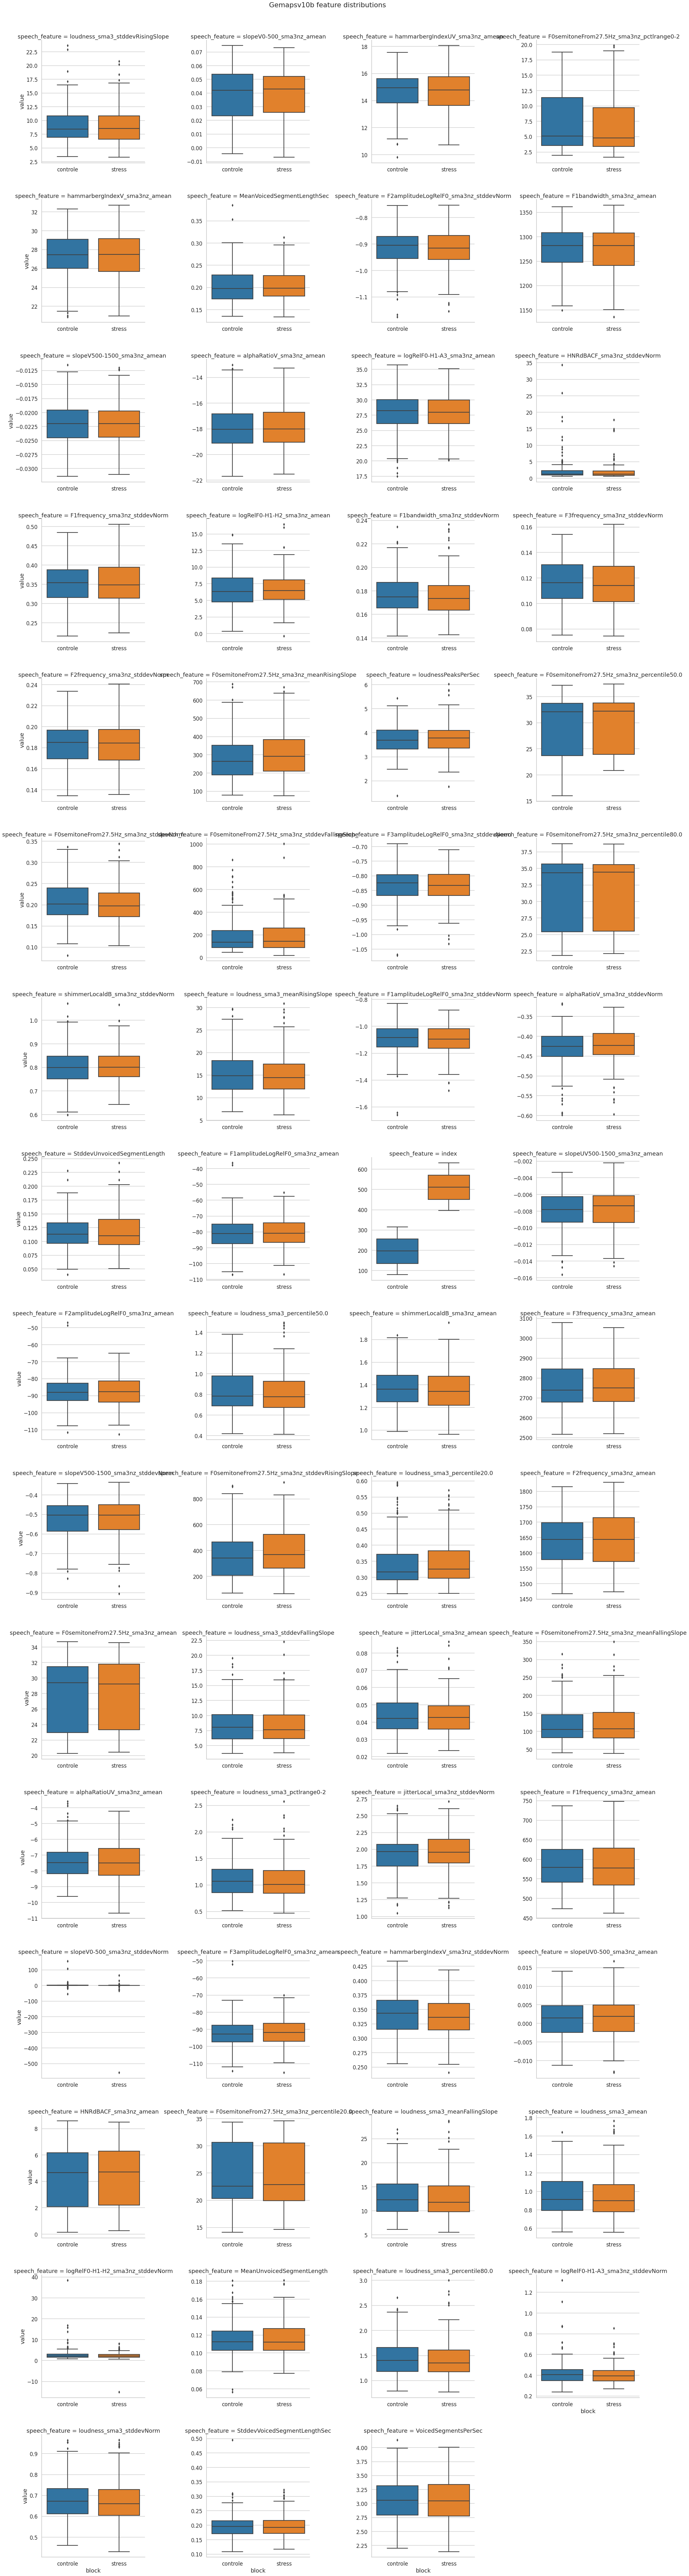

In [7]:
sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=pd.melt(
        frame=df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())],
        id_vars=["file", "fileName", "fileNum", "block", "participantNum"],
        value_vars=set(df_feat_tot.columns).difference(
            {
                "file",
                "start",
                "end",
                "fileName",
                "fileNum",
                "block",
                "bad_audio",
                "participantNum",
                # also to not visualize the LLD quantile's + counts
                *list(list(df_feat_tot.filter(like="q=").columns.values)
                + list(df_feat_tot.filter(like="nzcount").columns.values)),
            }
        ),
        value_name="value",
        var_name="speech_feature",
    ),
    x="block",
    y="value",
    col="speech_feature",
    col_wrap=4,
    height=7,
    kind="box",
    sharey=False,
    sharex=False,
)
g.fig.suptitle("Gemapsv10b feature distributions", y=1.01)
plt.subplots_adjust(wspace=0.6, hspace=0.3)

### Per participant difference plot

In [8]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values
mean_func = (
    df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())]
    .groupby(["participantNum", "block"])
    .mean()
    .reset_index()
)
mean_contr_func = mean_func[mean_func.block == "controle"].set_index("participantNum")
mean_stress_func = mean_func[mean_func.block == "stress"].set_index("participantNum")
feat_cols: List[str] = list(
    set(df_feat_tot.columns).difference(
        {
            "file",
            "start",
            "end",
            "fileName",
            "fileNum",
            "block",
            "bad_audio",
            "participantNum",
            # also to not visualize the LLD quantile's + counts
            *list(list(df_feat_tot.filter(like="q=").columns.values)
            + list(df_feat_tot.filter(like="nzcount").columns.values)),
        }
    )
)
#
mean_stress_min_contr_func = mean_stress_func[feat_cols] - mean_contr_func[feat_cols]

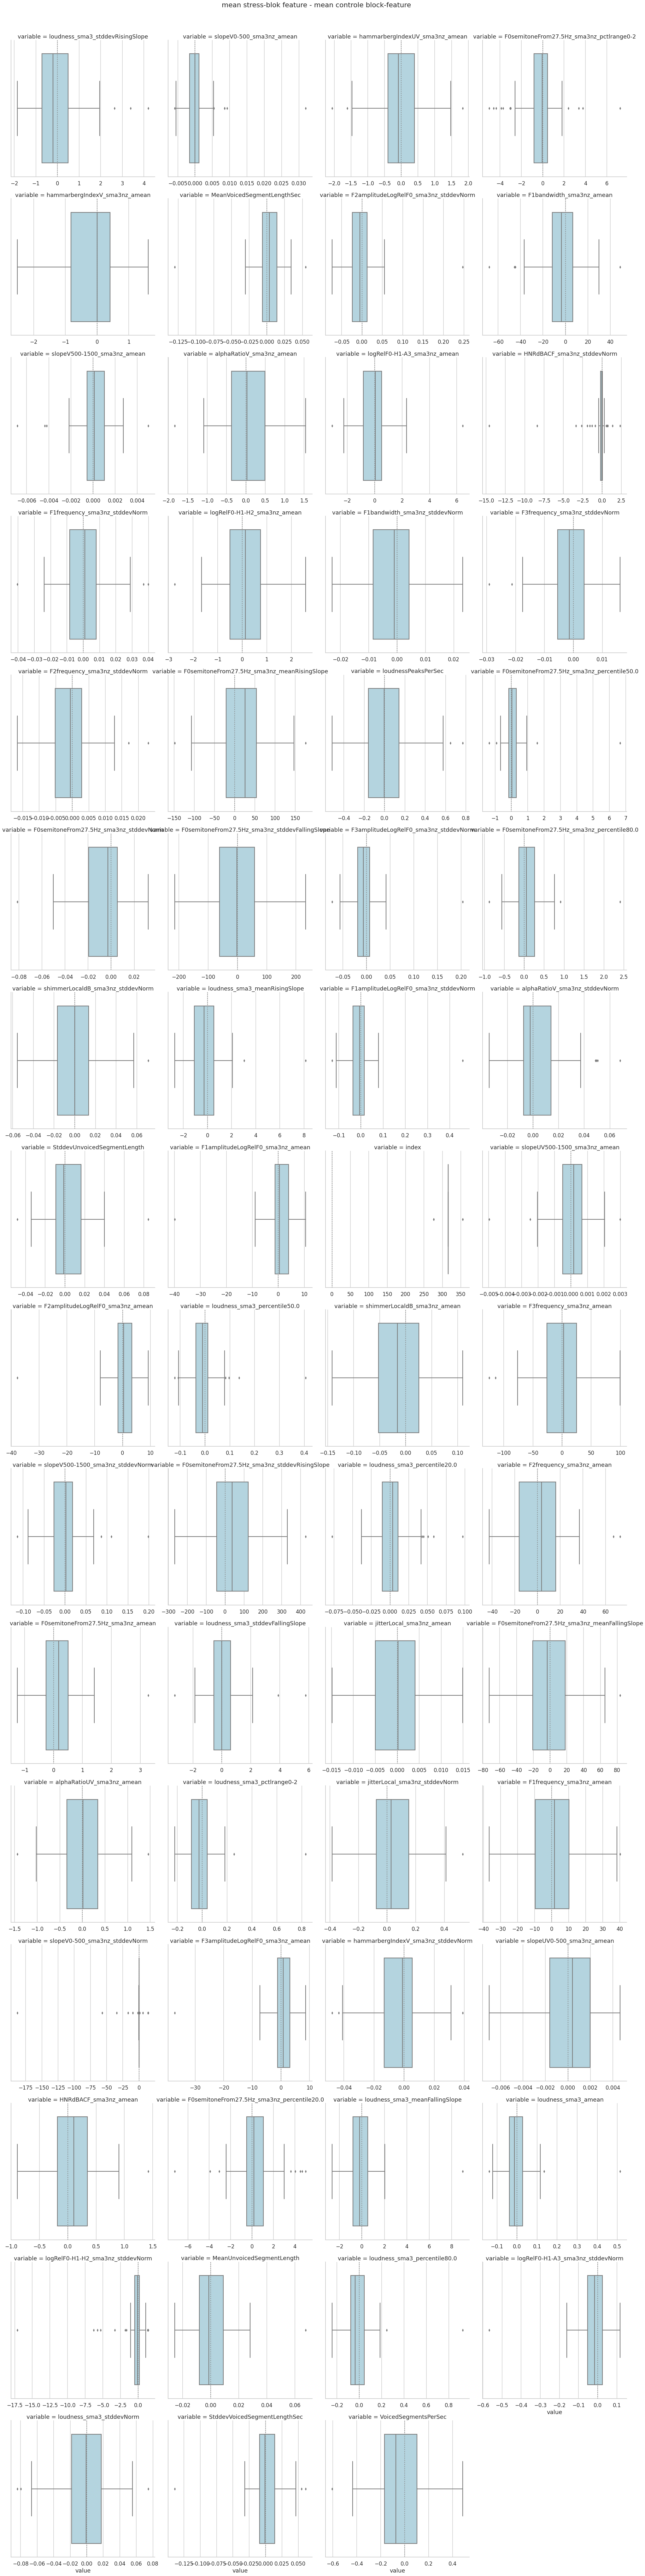

In [9]:
g = sns.catplot(
    data=mean_stress_min_contr_func[
        ~mean_stress_min_contr_func.index.isin(
            list(set(mean_stress_func.index)
            .difference(mean_contr_func.index)
            .union(set(mean_contr_func.index).difference(mean_stress_func.index)))
        )
    ].melt(),
    col="variable",
    x="value",
    kind="box",
    height=7,
    col_wrap=4,
    sharex=False,
    color='lightblue'
)
g.fig.suptitle('mean stress-blok feature - mean controle block-feature', y=1.01)
for ax in g.fig.axes:
    ax.axvline(x=0, color="grey", linestyle=":")

## `LLD's`: F0-range

### Block comparison

In [10]:
qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], [])
q_med = [0.5]

In [11]:
for sig in ["F0final_sma", "F0semitoneFrom27.5Hz_sma3nz"]:
    for (max_q, min_q) in list(zip(qs[::2], qs[1::2])):
        max_q_col = "_".join([sig, f"q={max_q}"])
        min_q_col = "_".join([sig, f"q={min_q}"])

        df_feat_tot[f"{sig}_qd={max_q}-{min_q}"] = (
            df_feat_tot[max_q_col] - df_feat_tot[min_q_col]
        )


/users/jonvdrdo/jonas/projects/context_aware_health_monitoring/.caw_venv37/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


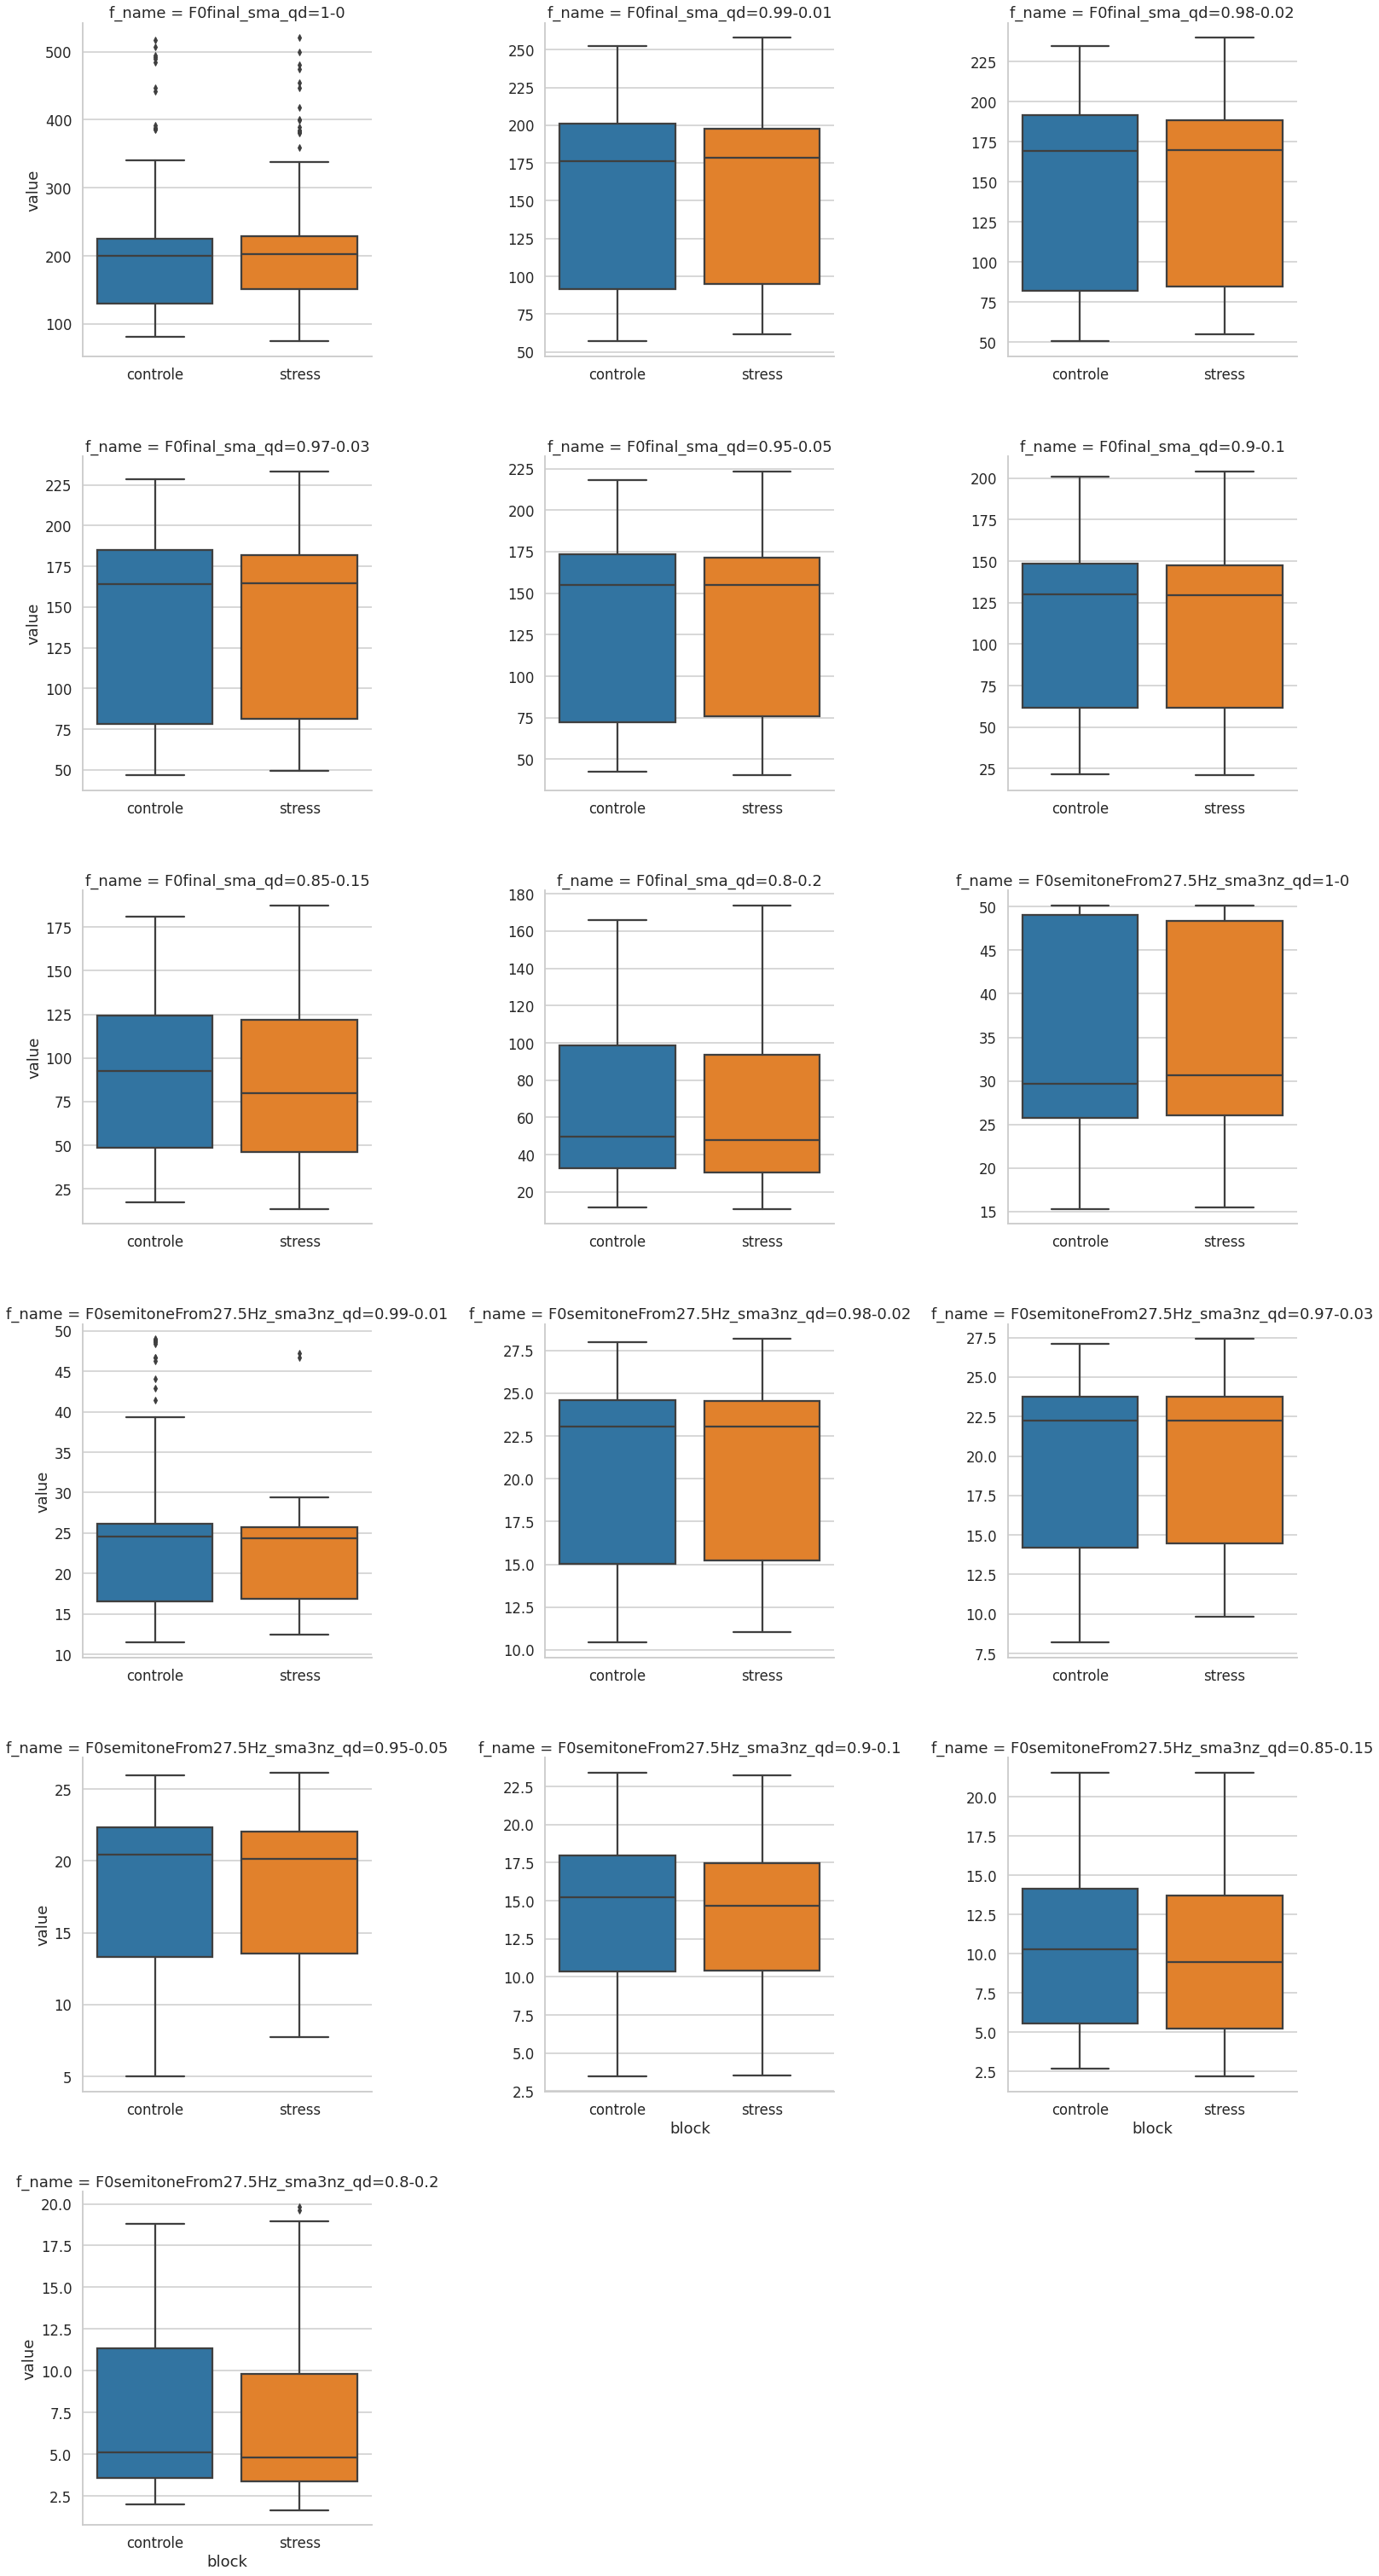

In [12]:
sns.catplot(
    data=pd.melt(
        frame=df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())],
        id_vars=["file", "fileName", "fileNum", "block", "participantNum"],
        value_vars=list(df_feat_tot.filter(like="qd=").columns.values),
        value_name="value",
        var_name="f_name",
    ),
    x="block",
    y="value",
    col="f_name",
    col_wrap=3,
    height=7,
    sharex=False,
    sharey=False,
    kind='box'
)
plt.subplots_adjust(wspace=0.6, hspace=0.3)

### Per participant difference plot

In [15]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values
mean_func = (
    df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())]
    .groupby(["participantNum", "block"])
    .mean()
    .reset_index()
)
mean_contr_func = mean_func[mean_func.block == "controle"].set_index("participantNum")
mean_stress_func = mean_func[mean_func.block == "stress"].set_index("participantNum")
feat_cols: List[str] = list(df_feat_tot.filter(like="qd=").columns.values)

mean_stress_min_contr_func = mean_stress_func[feat_cols] - mean_contr_func[feat_cols]

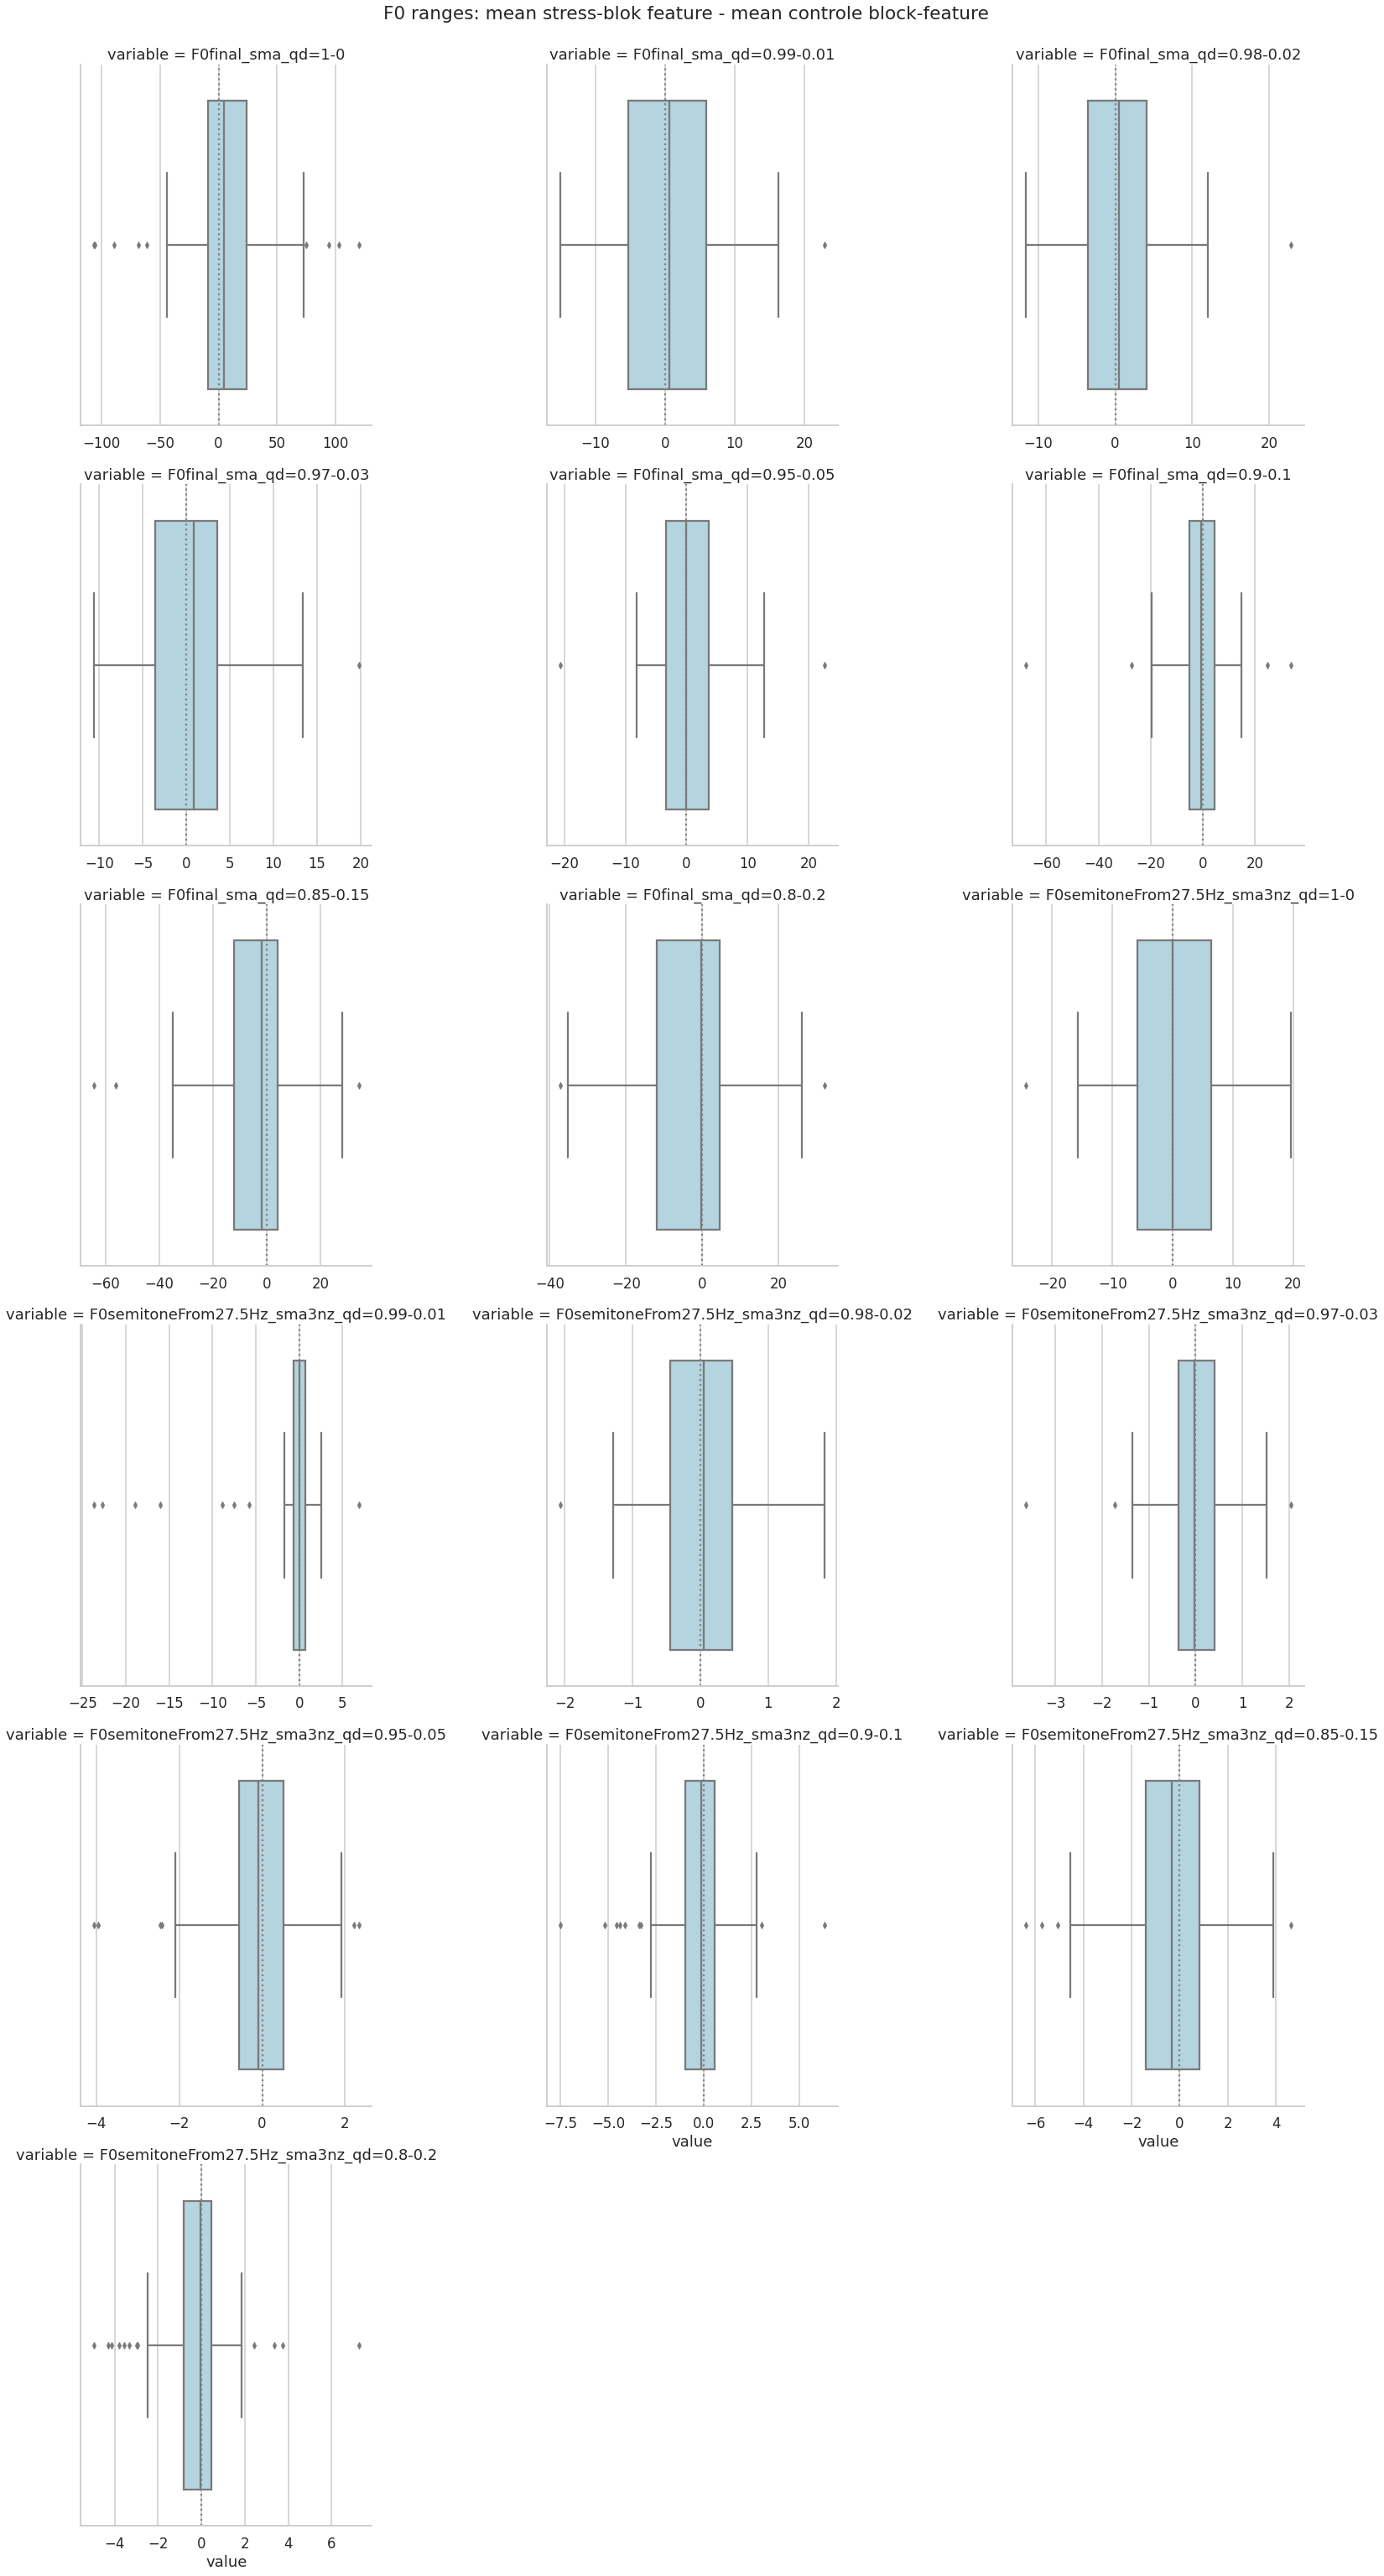

In [20]:
g = sns.catplot(
    data=mean_stress_min_contr_func[
        ~mean_stress_min_contr_func.index.isin(
            list(set(mean_stress_func.index)
            .difference(mean_contr_func.index)
            .union(set(mean_contr_func.index).difference(mean_stress_func.index)))
        )
    ].melt(),
    col="variable",
    x="value",
    kind="box",
    height=7,
    col_wrap=3,
    sharex=False,
    color='lightblue'
)
g.fig.suptitle('F0 ranges: mean stress-blok feature - mean controle block-feature', y=1.01)
for ax in g.fig.axes:
    ax.axvline(x=0, color="grey", linestyle=":")
plt.subplots_adjust(wspace=0.6)